In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## load and visualize

Optimal epsilon: -0.38, Minimum loss: 0.04879313705014211


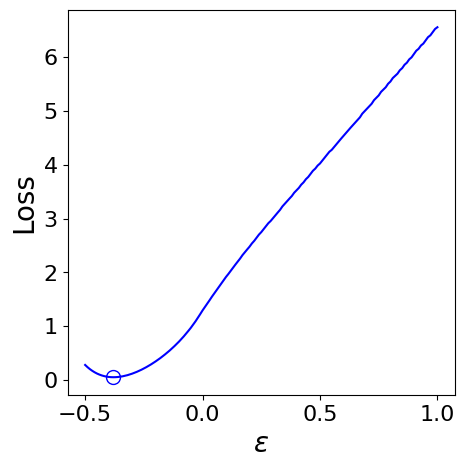

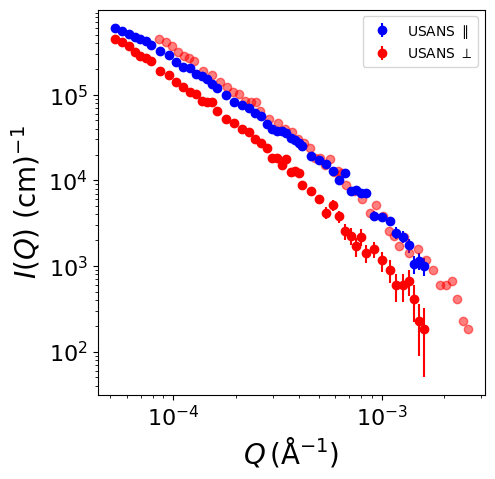

Low Q range: (-0.03395646, 0.03638733)
Mid Q range: (-0.08133716, 0.08950429)
High Q range: (-0.2799932, 0.3072851)


/tmp/ipykernel_679234/2881343985.py:196: RuntimeWarning: invalid value encountered in log10
  c = ax.pcolormesh(Qx_grid, Qy_grid, np.log10(I_grid), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid).astype(float))


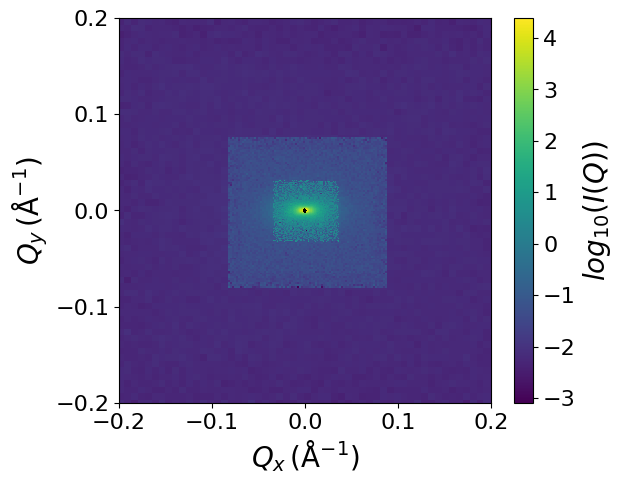

Optimal epsilon (SANS): -0.14999999999999997, Minimum loss (SANS): 3.014368208988506


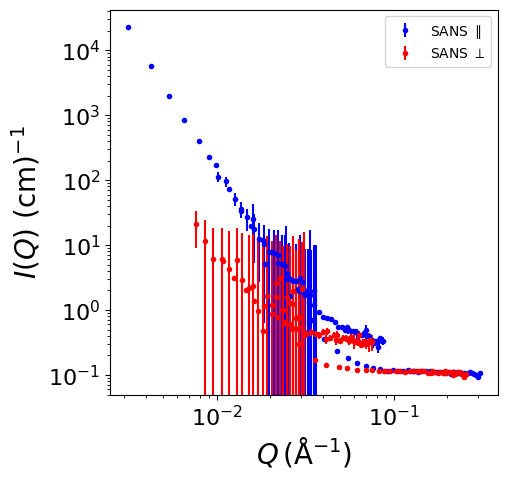

In [6]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

sample_id = "1"

filename_USANS_para = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_para_8mm.txt"
filename_USANS_perp = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_perp_8mm.txt"
filename_SANS_para = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_8m_Iqxqy.dat"
filename_SANS_para_mq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_inc_Iqxqy.dat"
filename_SANS_para_hq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf2_inc_Iqxqy.dat"
# load USANS data
data_USANS_para = np.genfromtxt(filename_USANS_para, skip_header=0, delimiter=',', filling_values=np.nan)
data_USANS_perp = np.genfromtxt(filename_USANS_perp, skip_header=0, delimiter=',', filling_values=np.nan)

Q_obs_usans_para = data_USANS_para[:, 0]
I_obs_usans_para = data_USANS_para[:, 1]
dI_obs_usans_para = data_USANS_para[:, 2]
Q_obs_usans_para_mask = Q_obs_usans_para > 5e-5
Q_obs_usans_para = Q_obs_usans_para[Q_obs_usans_para_mask]
I_obs_usans_para = I_obs_usans_para[Q_obs_usans_para_mask]
dI_obs_usans_para = dI_obs_usans_para[Q_obs_usans_para_mask]

Q_obs_usans_perp = data_USANS_perp[:, 0]
I_obs_usans_perp = data_USANS_perp[:, 1]
dI_obs_usans_perp = data_USANS_perp[:, 2]
Q_obs_usans_perp_mask = Q_obs_usans_perp > 5e-5
Q_obs_usans_perp = Q_obs_usans_perp[Q_obs_usans_perp_mask]
I_obs_usans_perp = I_obs_usans_perp[Q_obs_usans_perp_mask]
dI_obs_usans_perp = dI_obs_usans_perp[Q_obs_usans_perp_mask]

# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_usans_para = np.log(np.clip(I_obs_usans_para, 1e-300, None))
log_I_obs_usans_perp = np.log(np.clip(I_obs_usans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 3
coeffs_para = np.polyfit(Q_obs_usans_para, log_I_obs_usans_para, deg)
coeffs_perp = np.polyfit(Q_obs_usans_perp, log_I_obs_usans_perp, deg)

# Use an overlap Q grid for comparison
Q_min = max(Q_obs_usans_para.min(), Q_obs_usans_perp.min())
Q_max = min(Q_obs_usans_para.max(), Q_obs_usans_perp.max())
Q_ref = np.linspace(Q_min, Q_max, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_loss(epsilon, Q_ref, coeffs_para, coeffs_perp,
                   Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, Q_ref[m])
    log_I_perp = np.polyval(coeffs_perp, Q_perp[m])

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list = np.linspace(-0.5, 1.0, 151)
loss_list = np.array([
    calculate_loss(eps, Q_ref, coeffs_para, coeffs_perp,
                   Q_obs_usans_perp.min(), Q_obs_usans_perp.max())
    for eps in epsilon_list
])

optimal_epsilon = epsilon_list[np.nanargmin(loss_list)]
min_loss = np.nanmin(loss_list)

# Original smooth grid
Q_smooth = np.linspace(
    min(Q_obs_usans_para.min(), Q_obs_usans_perp.min()),
    max(Q_obs_usans_para.max(), Q_obs_usans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_para = np.polyval(coeffs_para, Q_smooth)
log_I_fit_perp = np.polyval(coeffs_perp, Q_smooth)

# Apply optimal stretch to PERP direction
Q_perp_stretched = (1 + optimal_epsilon) * Q_smooth
        
print(f"Optimal epsilon: {optimal_epsilon}, Minimum loss: {min_loss}")
    
# Find the optimal epsilon that minimizes the loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epsilon_list, loss_list, '-', color='blue')
ax.set_xlabel(r'$\epsilon$', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(optimal_epsilon, min_loss, 'bo', fillstyle='none', markersize=10)
plt.show()

# plot loaded USANS data
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(Q_obs_usans_para, I_obs_usans_para, yerr=dI_obs_usans_para, fmt='o', label='USANS $\parallel$', color='blue')
ax.errorbar(Q_obs_usans_perp, I_obs_usans_perp, yerr=dI_obs_usans_perp, fmt='o', label='USANS $\perp$', color='red')
# ax.plot(Q_smooth, np.exp(log_I_fit_para), '-', color='blue')
# ax.plot(Q_smooth, np.exp(log_I_fit_perp), '-', color='red')
# ax.plot(Q_smooth*(1 + optimal_epsilon), np.exp(log_I_fit_para), '--', color='green')
ax.plot(Q_obs_usans_perp/(1 + optimal_epsilon), I_obs_usans_perp, 'o', color='red', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()

# load SANS data
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS = np.genfromtxt(filename_SANS_para, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans = data_SANS[:, 0]
Qy_obs_sans = data_SANS[:, 1]
Ixy_obs_sans = data_SANS[:, 2]
dI_obs_sans = data_SANS[:, 3]

unique_Qx = np.unique(Qx_obs_sans)
unique_Qy = np.unique(Qy_obs_sans)

# Create a grid
Qx_grid, Qy_grid = np.meshgrid(unique_Qx, unique_Qy)

# Initialize grid for intensity values with NaN
I_grid = np.full(Qx_grid.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans)):
    x_idx = np.where(unique_Qx == Qx_obs_sans[i])[0][0]
    y_idx = np.where(unique_Qy == Qy_obs_sans[i])[0][0]
    I_grid[y_idx, x_idx] = Ixy_obs_sans[i]
    
# load SANS data (mq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_mq = np.genfromtxt(filename_SANS_para_mq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_mq = data_SANS_mq[:, 0]
Qy_obs_sans_mq = data_SANS_mq[:, 1]
Ixy_obs_sans_mq = data_SANS_mq[:, 2]
dI_obs_sans_mq = data_SANS_mq[:, 3]
unique_Qx_mq = np.unique(Qx_obs_sans_mq)
unique_Qy_mq = np.unique(Qy_obs_sans_mq)

# Create a grid
Qx_grid_mq, Qy_grid_mq = np.meshgrid(unique_Qx_mq, unique_Qy_mq)

# Initialize grid for intensity values with NaN
I_grid_mq = np.full(Qx_grid_mq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_mq)):
    x_idx = np.where(unique_Qx_mq == Qx_obs_sans_mq[i])[0][0]
    y_idx = np.where(unique_Qy_mq == Qy_obs_sans_mq[i])[0][0]
    I_grid_mq[y_idx, x_idx] = Ixy_obs_sans_mq[i]
    
# load SANS data (hq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_hq = np.genfromtxt(filename_SANS_para_hq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_hq = data_SANS_hq[:, 0]
Qy_obs_sans_hq = data_SANS_hq[:, 1]
Ixy_obs_sans_hq = data_SANS_hq[:, 2]
dI_obs_sans_hq = data_SANS_hq[:, 3]
unique_Qx = np.unique(Qx_obs_sans_hq)
unique_Qy = np.unique(Qy_obs_sans_hq)

# Create a grid
Qx_grid_hq, Qy_grid_hq = np.meshgrid(unique_Qx, unique_Qy)

# Initialize grid for intensity values with NaN
I_grid_hq = np.full(Qx_grid_hq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_hq)):
    x_idx = np.where(unique_Qx == Qx_obs_sans_hq[i])[0][0]
    y_idx = np.where(unique_Qy == Qy_obs_sans_hq[i])[0][0]
    I_grid_hq[y_idx, x_idx] = Ixy_obs_sans_hq[i]

# Define Q ranges for low, mid, and high Q SANS
low_Q_range = (Qx_obs_sans.min(), Qx_obs_sans.max())
mid_Q_range = (Qx_obs_sans_mq.min(), Qx_obs_sans_mq.max())
high_Q_range = (Qx_obs_sans_hq.min(), Qx_obs_sans_hq.max())

print(f"Low Q range: {low_Q_range}")
print(f"Mid Q range: {mid_Q_range}")
print(f"High Q range: {high_Q_range}")

# Visualize the processed grid
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(Qx_grid_hq, Qy_grid_hq, np.log10(I_grid_hq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_hq).astype(float))
c = ax.pcolormesh(Qx_grid_mq, Qy_grid_mq, np.log10(I_grid_mq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_mq).astype(float))
c = ax.pcolormesh(Qx_grid, Qy_grid, np.log10(I_grid), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid).astype(float))
ax.set_xlabel(r'$Q_x \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$Q_y \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.tick_params(axis='both', which='major', labelsize=16)
cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'$log_\mathrm{10}(I(Q))$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
ax.set_facecolor('k')
plt.show()

# pie_average
def pie_average_wedge(Qx, Qy, I, dI=None, *,
                      center_angle_rad=0.0,
                      half_width_rad=np.deg2rad(5.0),
                      nbins=120,
                      Qmin=None, Qmax=None,
                      use_weighted=True,
                      return_counts=False):
    """
    Pie-average intensity in a wedge around center_angle_rad.
    Angles are defined in standard polar coordinates: theta = arctan2(Qy, Qx).

    Parameters
    ----------
    Qx, Qy, I : 1D arrays
    dI : 1D array or None
        If provided and use_weighted=True, weights = 1/dI^2.
    center_angle_rad : float
        Wedge center angle. para ~ 0, perp ~ pi/2.
    half_width_rad : float
        Half wedge width (e.g., 5 degrees => +/-5 deg).
    nbins : int
        Number of radial Q bins.
    Qmin, Qmax : float or None
        Radial range. If None, inferred from wedge-selected points.
    use_weighted : bool
        If True and dI is provided, compute weighted mean.
        Else use simple mean.
    return_counts : bool
        If True, also return counts per bin.

    Returns
    -------
    Q_centers : 1D array
    I_binned  : 1D array
    dI_binned : 1D array (if dI provided), else None
    counts    : 1D array (if return_counts=True)
    """
    Qx = np.asarray(Qx); Qy = np.asarray(Qy); I = np.asarray(I)

    # Basic finite mask
    m = np.isfinite(Qx) & np.isfinite(Qy) & np.isfinite(I)
    if dI is not None:
        dI = np.asarray(dI)
        m &= np.isfinite(dI) & (dI > 0)

    Qx, Qy, I = Qx[m], Qy[m], I[m]
    dI_use = dI[m] if dI is not None else None

    Q = np.sqrt(Qx**2 + Qy**2)
    theta = np.arctan2(Qy, Qx)  # (-pi, pi]

    # Smallest signed angular difference in [-pi, pi]
    dtheta = (theta - center_angle_rad + np.pi) % (2*np.pi) - np.pi
    mw = np.abs(dtheta) <= half_width_rad

    Qw, Iw = Q[mw], I[mw]
    dIw = dI_use[mw] if dI_use is not None else None

    if Qw.size == 0:
        raise ValueError("No points found in wedge; widen half_width_rad or check data orientation.")

    if Qmin is None: Qmin = np.nanmin(Qw)
    if Qmax is None: Qmax = np.nanmax(Qw)
    if Qmax <= Qmin:
        raise ValueError("Invalid Q range after wedge selection.")

    edges = np.linspace(Qmin, Qmax, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_id = np.digitize(Qw, edges) - 1
    good = (bin_id >= 0) & (bin_id < nbins)

    bin_id = bin_id[good]
    Iw = Iw[good]
    if dIw is not None:
        dIw = dIw[good]

    counts = np.bincount(bin_id, minlength=nbins)

    if (dIw is not None) and use_weighted:
        w = 1.0 / (dIw**2)
        sumw = np.bincount(bin_id, weights=w, minlength=nbins)
        sumwI = np.bincount(bin_id, weights=w*Iw, minlength=nbins)
        I_binned = np.divide(sumwI, sumw, out=np.full(nbins, np.nan), where=(sumw > 0))

        # standard error of weighted mean (measurement-noise-only)
        dI_binned = np.divide(1.0, np.sqrt(sumw), out=np.full(nbins, np.nan), where=(sumw > 0))
    else:
        sumI = np.bincount(bin_id, weights=Iw, minlength=nbins)
        I_binned = np.divide(sumI, counts, out=np.full(nbins, np.nan), where=(counts > 0))
        dI_binned = None
        if dIw is not None:
            # conservative: combine reported dI by RMS / sqrt(N)
            sum_dI2 = np.bincount(bin_id, weights=dIw**2, minlength=nbins)
            dI_binned = np.divide(np.sqrt(sum_dI2), counts, out=np.full(nbins, np.nan), where=(counts > 0))

    # Keep only bins with data
    keep = counts > 0
    out = (centers[keep], I_binned[keep])
    if dI is not None:
        out = out + (dI_binned[keep],)
    if return_counts:
        out = out + (counts[keep],)
    return out


# ---- Use it for para and perp ----
wdeg = 5  # +/- 5 degrees wedge
nbins = 120

# para: along +Qx => theta = 0
Q_obs_sans_para, I_obs_sans_para, dI_obs_sans_para = pie_average_wedge(
    Qx_obs_sans, Qy_obs_sans, Ixy_obs_sans, dI_obs_sans,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp, I_obs_sans_perp, dI_obs_sans_perp = pie_average_wedge(
    Qx_obs_sans, Qy_obs_sans, Ixy_obs_sans, dI_obs_sans,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_mq, I_obs_sans_para_mq, dI_obs_sans_para_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_mq, I_obs_sans_perp_mq, dI_obs_sans_perp_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_hq, I_obs_sans_para_hq, dI_obs_sans_para_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_hq, I_obs_sans_perp_hq, dI_obs_sans_perp_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# Combine high Q, mid Q, and low Q pied data
Q_obs_sans_para = np.concatenate((Q_obs_sans_para, Q_obs_sans_para_mq, Q_obs_sans_para_hq))
I_obs_sans_para = np.concatenate((I_obs_sans_para, I_obs_sans_para_mq, I_obs_sans_para_hq))
dI_obs_sans_para = np.concatenate((dI_obs_sans_para, dI_obs_sans_para_mq, dI_obs_sans_para_hq))

Q_obs_sans_perp = np.concatenate((Q_obs_sans_perp, Q_obs_sans_perp_mq, Q_obs_sans_perp_hq))
I_obs_sans_perp = np.concatenate((I_obs_sans_perp, I_obs_sans_perp_mq, I_obs_sans_perp_hq))
dI_obs_sans_perp = np.concatenate((dI_obs_sans_perp, dI_obs_sans_perp_mq, dI_obs_sans_perp_hq))

# Sort the combined data by Q
sorted_indices_para = np.argsort(Q_obs_sans_para)
Q_obs_sans_para = Q_obs_sans_para[sorted_indices_para]
I_obs_sans_para = I_obs_sans_para[sorted_indices_para]
dI_obs_sans_para = dI_obs_sans_para[sorted_indices_para]

sorted_indices_perp = np.argsort(Q_obs_sans_perp)
Q_obs_sans_perp = Q_obs_sans_perp[sorted_indices_perp]
I_obs_sans_perp = I_obs_sans_perp[sorted_indices_perp]
dI_obs_sans_perp = dI_obs_sans_perp[sorted_indices_perp]

# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_sans_para = np.log(np.clip(I_obs_sans_para, 1e-300, None))
log_I_obs_sans_perp = np.log(np.clip(I_obs_sans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 5
coeffs_sans_para = np.polyfit(Q_obs_sans_para, log_I_obs_sans_para, deg)
coeffs_sans_perp = np.polyfit(Q_obs_sans_perp, log_I_obs_sans_perp, deg)

# Use an overlap Q grid for comparison
Q_min_sans = max(Q_obs_sans_para.min(), Q_obs_sans_perp.min())
Q_max_sans = min(Q_obs_sans_para.max(), Q_obs_sans_perp.max())
Q_ref_sans = np.linspace(Q_min_sans, Q_max_sans, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_loss_sans(epsilon, Q_ref, coeffs_para, coeffs_perp,
                        Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, Q_ref[m])
    log_I_perp = np.polyval(coeffs_perp, Q_perp[m])

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list_sans = np.linspace(-0.5, 1.0, 151)
loss_list_sans = np.array([
    calculate_loss_sans(eps, Q_ref_sans, coeffs_sans_para, coeffs_sans_perp,
                        Q_obs_sans_perp.min(), Q_obs_sans_perp.max())
    for eps in epsilon_list_sans
])

optimal_epsilon_sans = epsilon_list_sans[np.nanargmin(loss_list_sans)]
min_loss_sans = np.nanmin(loss_list_sans)

# Original smooth grid
Q_smooth_sans = np.linspace(
    min(Q_obs_sans_para.min(), Q_obs_sans_perp.min()),
    max(Q_obs_sans_para.max(), Q_obs_sans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_sans_para = np.polyval(coeffs_sans_para, Q_smooth_sans)
log_I_fit_sans_perp = np.polyval(coeffs_sans_perp, Q_smooth_sans)

# Apply optimal stretch to PERP direction
Q_perp_stretched_sans = (1 + optimal_epsilon_sans) * Q_smooth_sans

print(f"Optimal epsilon (SANS): {optimal_epsilon_sans}, Minimum loss (SANS): {min_loss_sans}")

fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(Q_obs_sans_para, I_obs_sans_para, yerr=dI_obs_sans_para, fmt='.', label='SANS $\parallel$', color='blue')
ax.errorbar(Q_obs_sans_perp, I_obs_sans_perp, yerr=dI_obs_sans_perp, fmt='.', label='SANS $\perp$', color='red')
# ax.plot(Q_obs_sans_perp/(1+optimal_epsilon_sans), I_obs_sans_perp, 'o', color='red', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()

In [3]:
loss_list

array([0.2771088 , 0.23623655, 0.20020361, 0.16901123, 0.14173057,
       0.11844787, 0.09910025, 0.08305683, 0.07045349, 0.06079554,
       0.05415902, 0.05014025, 0.04879314, 0.04986652, 0.05312165,
       0.05864152, 0.0660843 , 0.07558829, 0.08694463, 0.09988258,
       0.11467244, 0.13084522, 0.14878642, 0.16823526, 0.18881106,
       0.21111414, 0.23481629, 0.25989802, 0.28584228, 0.31360789,
       0.34274046, 0.37259622, 0.40445404, 0.43774114, 0.47249673,
       0.50876925, 0.5456534 , 0.58507341, 0.62621143, 0.66915626,
       0.71274407, 0.75952963, 0.80845338, 0.85965155, 0.91327367,
       0.96775295, 1.02661964, 1.08843906, 1.1534199 , 1.22178748,
       1.29145128, 1.35420091, 1.41812843, 1.48132359, 1.54697767,
       1.60865017, 1.66916119, 1.73298533, 1.79125269, 1.85345959,
       1.91493884, 1.9694054 , 2.02879876, 2.08726138, 2.14473955,
       2.20118718, 2.25656562, 2.31927747, 2.37275008, 2.42506273,
       2.47620396, 2.53590665, 2.58494454, 2.64315771, 2.70077